In [2]:
import numpy as np
import pandas as pd
import math
import os
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import metrics
from sklearn.decomposition import PCA
from lime import lime_tabular
from lime import submodular_pick
from matplotlib import pyplot as plt
from math import sqrt
%matplotlib inline

plt.style.use("seaborn")


# Check loops
def checkLoops(expName):
    data = ds.loc[:,['caseId', 'activity']]

    actCount = data.groupby(data.columns.tolist()).size().reset_index().\
                        rename(columns={0:'records'})
    print(actCount.describe())
    #print(actCount[:20])
    
def checkCorrelation():
    ds['Accept Claim'] = ds['Accept Claim'].astype(bool)
    print('Accept == label (1)', ds['Accept Claim'].equals(ds['label']))

    ds['Reject Claim'] = ds['Reject Claim'].astype(bool)
    print('Reject == label (0)', ds['Reject Claim'].equals(~ds['label']))
    
# Delete out loops, Input: trace (lista), Ouput: traceSemLoop (lista)
def dropLoopsInTraces(traceList):
    prev = object()
    traceList = [prev := v for v in traceList if prev != v]
    return traceList

# Transform the log into dataset of traces
def f_Traces(x):
    return pd.Series(dict(trace='%s' % ','.join(x['activity']),
                      nrEvents=x['activity'].count(),
                      target=int(x[target].mean())))

# Transform the log into dataset of traces considering resources
def f_TracesComplex(x):
    return pd.Series(dict(tracea='%s' % ','.join(x['activity']),
                          tracer='%s' % ','.join(x['Resource']),
                          nrEvents=x['activity'].count(),
                          target=int(x[target].mean())))

# Load event log data
def loadData(data, column_caseId, column_activity):   
    global ds, target, class_names, expName
    ds = pd.read_csv('data/' + data.split('_')[0] + '.csv', sep=',')
    target = 'label'
    class_names = [0, 1]
    ds = ds.rename(columns={column_caseId: "caseId", column_activity: "activity"})
    expName = data
    print("Data loaded...")

# Pre-process data: simple indexing, considering trace positions,  Input: dataset of traces (dataframe), Ouput: dataset of activity per position in trace (dataframe)
def simpleIndexingNoLoops():
    global ds
    ds = ds.groupby('caseId').apply(f_Traces)
    ds_new = pd.DataFrame(columns=['caseId', 'trace', 'nrEvents', target])
    for item in ds.iterrows():
        noduplicates = dropLoopsInTraces(item[1][0].split(','))
        ds_new.loc[len(ds_new)] = [int(item[0]), ','.join(noduplicates), len(noduplicates), int(item[1][2])]

    ds_new[['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13']] = ds_new['trace'].str.split(',', expand=True)
    ds_new = ds_new.drop(['caseId', 'trace', 'nrEvents'], axis=1)
    ds_new.to_csv('results/' + expName + '_traces.csv')
    ds = ds_new.copy()
    print("Data preprocessed... SIMPLE-INDEXING ENCODING")

    
# Pre-process data: frequency indexing, considering frequency of occurrence of an activity in the trace
def frequencyIndexingWithLoops():
    global ds
    ds.loc[ds.activity =='Accept Claim','activity']='Decide claim'
    ds.loc[ds.activity =='Reject Claim','activity']='Decide claim'
    ds_new = pd.DataFrame()
    ds_new[['caseId', 'activity','label']] = ds[['caseId', 'activity','label']].copy()
    ds_new['val'] = 1
    ds_new = ds_new.groupby(['caseId', 'label', 'activity'])['val'].sum().unstack(fill_value=0)
    ds_new.reset_index(level = 'label', inplace=True)
    ds_new.reset_index(level = 'caseId', inplace=True)
    ds_new.drop(['caseId'], axis = 1, inplace=True)
    ds_new.to_csv('results/' + expName + '_frequencytraces.csv')
    ds = ds_new.copy()
    print("Data preprocessed... FREQUENCY-INDEXING ENCODING")

# Apply one-hot encoding and split data
def encodingAndSplitData():
    global X, y, X_train, X_test, y_train, y_test

    X = pd.get_dummies(ds.drop(columns=[target]))
    y = ds[target].astype(bool)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Set the random_state parameter to 42 for getting the same split
    X_train = X
    X_test = X
    y_train = y
    y_test = y
    X_train.to_csv("results/"+ expName + "_XTrain.csv")
    X_test.to_csv("results/"+ expName + "_XTest.csv")
    print("Data splitted...")
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    print('X_test shape: ', X_test.shape)
    print('y_test shape: ', y_test.shape)
    
# Train um RandomForestClassifier from ScikitLearn
def trainRFModel():
    global model
    model = RandomForestClassifier(random_state = np.random.seed(42))
    model.fit(X_train, y_train)
    #Return the mean accuracy on the given test data and label
    score = model.score(X_test, y_test)
    print('Model trained...')
    print('Score (mean accuracy): ', score)
    y_pred = model.predict(X_test)
    acc=metrics.accuracy_score(y_test, y_pred)
    print('Accuracy (metrics) is:', acc)
          

# Apply Lime for an instance, Input: CaseId (int), Output: LimeExp (lime object)
def applyLimeIn(points, nrFeatures):
    explainer = lime_tabular.LimeTabularExplainer(
                                                    training_data=np.array(X_train),
                                                    feature_names=X_train.columns,
                                                    class_names=class_names,
                                                    mode='classification')

    exp_points = []
    exp_list = []

    for idx in points:
        exp = explainer.explain_instance(data_row=X_train.loc[idx], predict_fn=model.predict_proba, num_features=nrFeatures)
        exp_list = exp.as_list()
        exp_list.append(round(model.predict_proba([X_train.loc[idx]])[0, 0], 2))
        exp_list.append(round(model.predict_proba([X_train.loc[idx]])[0, 1], 2))
        exp_list.append(ds.loc[idx, target]) #exp_list.append(ds_new.loc[idx, target])
        exp_list.append(idx)
        exp_points.append(exp_list)
    fileName = "results/"+ expName + "_explanations.csv"
    with open(fileName, "w") as file:
        for row in exp_points:
            file.write("%s\n" % ';'.join(str(col) for col in row))
    print("Explanations file created... " + fileName)

    
# Apply SP-Lime
def applySPLimeIn(sampleSize, nrFeatures, nrExplanations):
    explainer = lime_tabular.LimeTabularExplainer(
                                                    training_data=np.array(X_train),
                                                    feature_names=X_train.columns,
                                                    class_names=class_names,
                                                    mode='classification')

    training_data=np.array(X_train)
    sp_obj = submodular_pick.SubmodularPick(explainer, data=training_data, predict_fn=model.predict_proba, sample_size=sampleSize, num_features=nrFeatures, num_exps_desired=nrExplanations)
    exp_points = sp_obj.sp_explanations[9].as_list()
    fileName = "results/"+ expName + "_explSPLIME.csv"
    with open(fileName, "w") as file:
        for row in exp_points:
            file.write("%s\n" % ';'.join(str(col) for col in row))
    print("Explanations with SP-LIME file created... "+fileName)

# Plot results from file generated by the LIME module, Input: Number of figures per row (int), Experiment Name (str)
def plotLimeResults(plotsPerRow, expName):        
    i, j = 0, 0
    fileName = "results/"+ expName + "_explLime.csv"
    with open(fileName, "r") as file:
        exp_points = list(file)
    exp_points = [x.rstrip() for x in exp_points]
    exp_points = [list(x.split(';')) for x in exp_points]

    # Graph multiplot
    fig, axs = plt.subplots(nrows=math.ceil(len(exp_points) / plotsPerRow), ncols=plotsPerRow, constrained_layout=True, figsize=(20, 20))  # #squeeze=False, you can force the result to be a 2D-array, independant of the number or arrangement of the subplots
    fig.suptitle('Experiment: %s' % expName, fontsize=20)  # title for entire figure

    exp_list = []
    for exp_list in exp_points:
        exp_list = [x.strip('(') for x in exp_list]
        exp_list = [x.strip(')') for x in exp_list]
        exp_list = [x.split(', ') for x in exp_list]
        names = [x[0].strip("\'") for x in exp_list[:-4]]  # Y
        names = [n.rpartition('.0')[0] for n in names]
        vals = [round(float(x[1]), 3) for x in exp_list[:-4]]  # X
        pos = np.arange(len(exp_list) - 4) + .5
        prob0 = exp_list[len(exp_list) - 4][0]
        prob1 = exp_list[len(exp_list) - 3][0]
        y_target = exp_list[len(exp_list) - 2][0]
        idx = exp_list[len(exp_list) - 1][0]
        vals.reverse()
        names.reverse()
        colors = ['green' if x > 0 else 'red' for x in vals]
        axs[i][j].set_title('Case Id: %s\nProbability for class 0 = %s \nProbability for class 1 = %s\n Target/Y: %s' % (idx,
                                                                                                                      str(prob0),
                                                                                                                      str(prob1),
                                                                                                                      y_target))
        axs[i][j].barh(pos, vals, align='center', color=colors)
        axs[i][j].set_yticks(pos, names)
        j += 1
        if j % plotsPerRow == 0:
            i += 1
            j = 0

    plt.show()
    fig.savefig(str("results/" + expName + "_plotLime.jpg"), bbox_inches='tight')
    print('Figure saved...' + "results/" + expName + "_plotLime.jpg")

# plot LIME-SP results in a a global way ***not working yet***
def plotLimeSPResults(sp_obj):
    # Plot all explanations
    #[explainer.as_pyplot_figure(label=explainer.available_labels()[0]) for explainer in sp_obj.sp_explanations];
    i=0
    for explainer in sp_obj.sp_explanations:
        fig = explainer.as_pyplot_figure(label=explainer.available_labels()[0])        
        fig.savefig(str("results/" + expName + "_SPLime"+str(i)+".jpg"), bbox_inches='tight')
        i += 1
    
    
    # Make it into a dataframe SP-LIME
    W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)

    # Getting SP predictions
    W_pick['_Prediction <= ----'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]

    W_pick.columns = formatColumns(W_pick.columns)
    W_pick.sort_index(axis=1, inplace = True)

    W_pick.to_csv("results/"+ expName + "_WmatrixSPLime.csv")
    print('Results saved...' + "results/" + expName + "_WmatrixSPLime.jpg")

    #Making a dataframe of all the explanations of sampled points SIMPLE - LIME
    W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
    W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]
    W.columns = formatColumns(W.columns)
    W.sort_index(axis=1, inplace = True)
    W.to_csv("results/"+ expName + "_WfullLime.csv")
    print('Results saved...' + "results/" + expName + "_WfullLime.csv")
    
def formatColumns(listColumnsName):
    names = []
    i=0
    for name in listColumnsName:
        if name[0] == '0':
            name = name[7:]    
        names.append(name[:-8]+'='+name[len(name)-4:-3])
        i=+ 1
    return names


In [5]:
ds

,CaseId,label,Register,Create Questionnaire,Send Questionnaire,Skip Questionnaire,Receive Questionnaire Response,High Medical History,High Insurance Check,Contact Hospital,...,Low Insurance Check,Decide Claim,Prepare Notification Content,Send Notification by Post,Notify by Post,Send Notification by e-mail,Notify by e-mail,Send Notification by Phone,Notify by Phone,Archive
0,0,True,1,1,1,0,1,0,0,0,...,1,1,1,0,0,1,1,1,1,1
1,1,False,1,1,1,0,1,1,1,1,...,0,1,1,1,1,1,1,0,0,1
2,2,False,1,1,1,1,0,0,0,0,...,1,1,1,0,0,1,1,0,0,1
3,3,False,1,1,1,0,1,1,1,1,...,0,1,1,1,1,0,0,0,0,1
4,4,False,1,1,1,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,3195,True,1,1,1,0,1,0,0,0,...,1,1,1,0,0,0,0,1,1,1
3196,3196,False,1,1,1,1,0,1,1,1,...,0,1,1,1,1,1,1,1,1,1
3197,3197,True,1,1,1,0,1,0,0,0,...,1,1,1,0,0,1,1,1,1,1
3198,3198,True,1,1,1,0,1,0,0,0,...,1,1,1,0,0,0,0,1,1,1


Exp  trainMarcelo_completoTrainFullTestFull
Data loaded...
Data splitted...
X_train shape:  (3200, 19)
y_train shape:  (3200,)
X_test shape:  (3200, 19)
y_test shape:  (3200,)
-----------------------------
5- Todas as instâncias (treina e testa com tudo) - RF
RF trained...
Accuracy (metrics) is: 1.0
acc RF  1.0
-----------------------------
6- Todas as instâncias (treina e testa com tudo) - KNN
GridSearchCV KNN k --->  {'n_neighbors': 2}
KNN trained...
acc knn  1.0


C:\Users\ani_c\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ani_c\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ani_c\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ani_c\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ani_c\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

Results saved...results/trainMarcelo_completoTrainFullTestFull_WmatrixSPLime.jpg
Results saved...results/trainMarcelo_completoTrainFullTestFull_WfullLime.csv


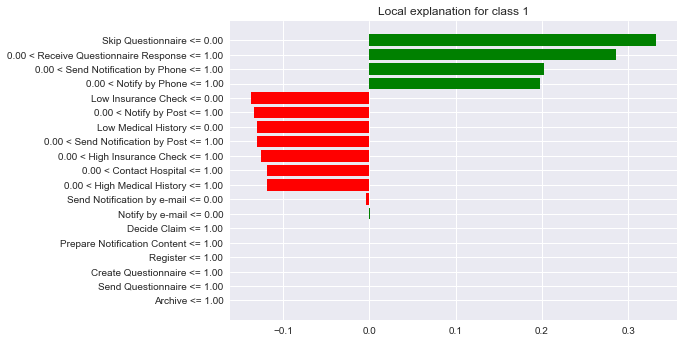

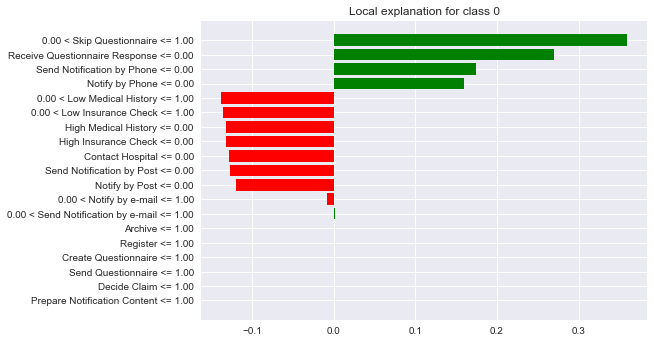

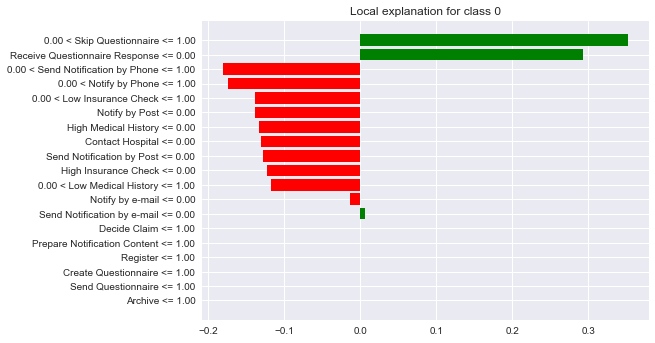

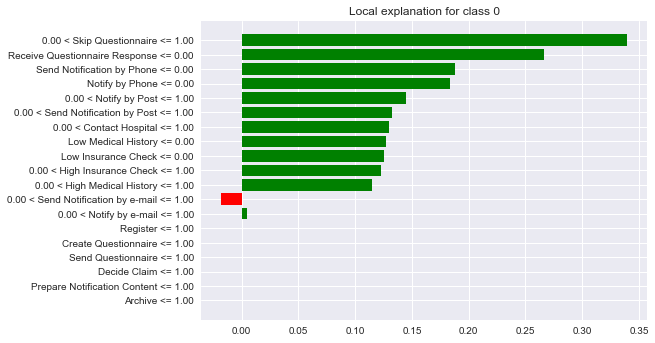

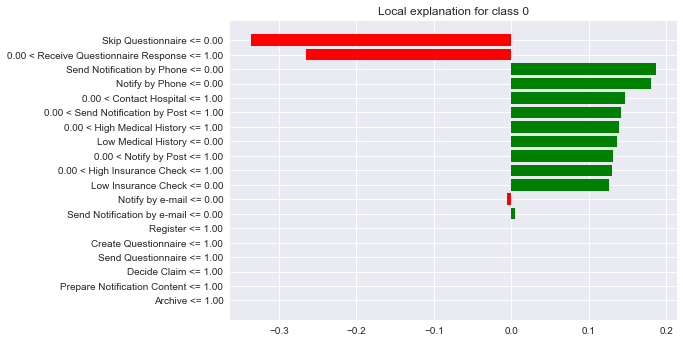

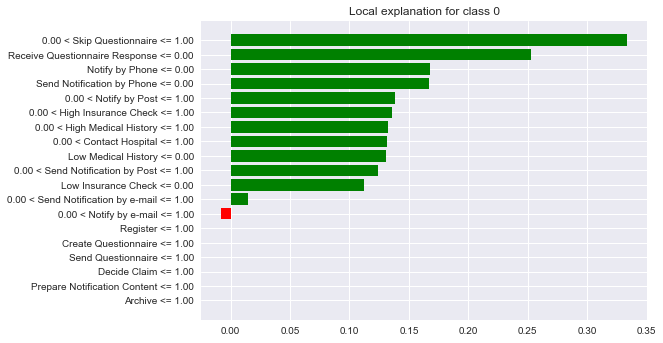

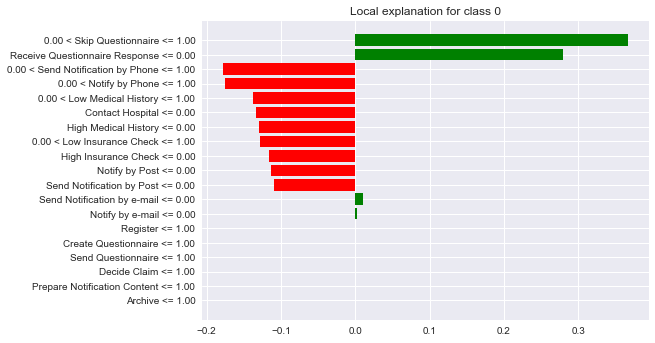

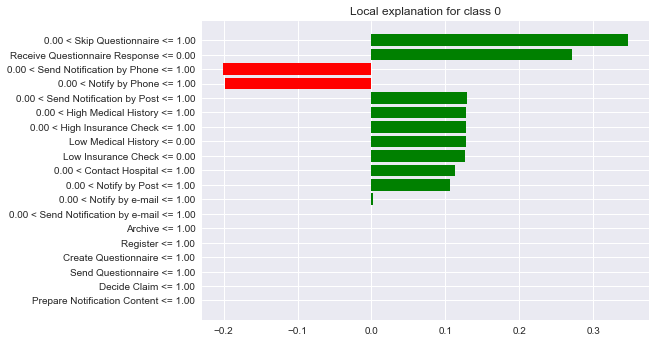

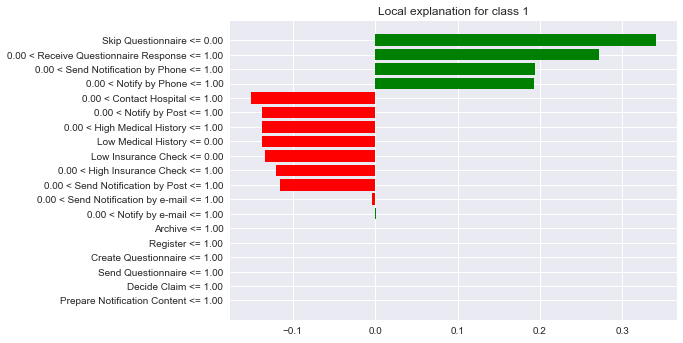

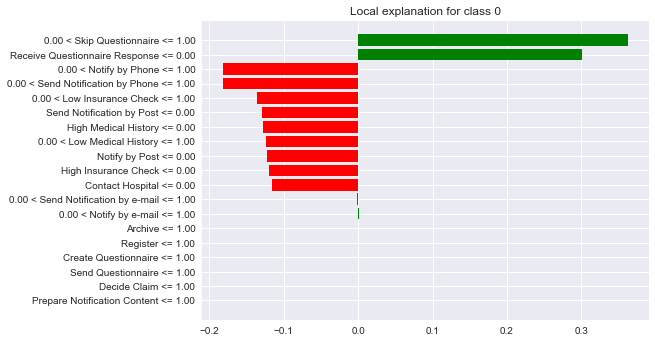

In [10]:
####################################
# EXPERIMETS ARTICLE completo
####################################
expName = 'trainMarcelo_completoTrainFullTestFull'
print("Exp ", expName)


target = 'label'
class_names = [0, 1]

#global ds, target, class_names, expName

ds = pd.read_csv('data/' + expName.split('_')[0] + '.csv', sep=',')
print("Data loaded...")

# Select type of modeling for traces in log
#frequencyIndexingWithLoops()

#global ds,X, y, X_train, X_test, y_train, y_test

ds.drop(columns=['CaseId'], axis = 1, inplace=True)
X = ds.drop(columns=[target])
y = ds[target].astype(bool)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Set the random_state parameter to 42 for getting the same split
X_train = X
X_test = X
y_train = y
y_test = y
X_train.to_csv("results/"+ expName + "_XTrain.csv")
X_test.to_csv("results/"+ expName + "_XTest.csv")
print("Data splitted...")
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
# Train a ML model
#encodingAndSplitData()
#trainRFModel()

print("-----------------------------")
print("5- Todas as instâncias (treina e testa com tudo) - RF")
model = RandomForestClassifier(random_state = np.random.seed(42))
model.fit(X_train, y_train)
#Return the mean accuracy on the given test data and label
score = model.score(X_test, y_test)
print('RF trained...')

#print('Score (mean accuracy): ', score)
y_pred = model.predict(X_test)
acc=metrics.accuracy_score(y_test, y_pred)
print('Accuracy (metrics) is:', acc)
          
y_pred=model.predict(X_test) #make prediction on test set
acc=metrics.accuracy_score(y_test, y_pred)
print('acc RF ', acc)

print("-----------------------------")
print("6- Todas as instâncias (treina e testa com tudo) - KNN")

from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsClassifier()

modelknn = GridSearchCV(knn, params, cv=5)
modelknn.fit(X_train,y_train)
print('GridSearchCV KNN k ---> ', modelknn.best_params_)
print('KNN trained...')

y_pred=modelknn.predict(X_test) #make prediction on test set
acc=metrics.accuracy_score(y_test, y_pred)
print('acc knn ', acc)

# SP-LIME

training_dataSPLime=np.array(X_train)


explainer = lime_tabular.LimeTabularExplainer(
                                                    training_data=training_dataSPLime,
                                                    feature_names=X_train.columns,
                                                    class_names=class_names,
                                                    mode='classification')


sp_obj = submodular_pick.SubmodularPick(explainer, data=training_dataSPLime, predict_fn=modelknn.predict_proba, num_features=20, num_exps_desired=10)
plotLimeSPResults(sp_obj)

In [ ]:
expName = 'train2_regras'
loadData(expName, 'Case ID', 'Activity')

ds_new = pd.DataFrame()
ds_new[['caseId', 'activity','label']] = ds[['caseId', 'activity','label']].copy()
ds_new['val'] = 1
ds_new = ds_new.groupby(['caseId', 'label', 'activity'])['val'].sum().unstack(fill_value=0)
ds_new.reset_index(level = 'label', inplace=True)
ds_new.reset_index(level = 'caseId', inplace=True)
ds_new.drop(['caseId'], axis = 1, inplace=True)
ds_new.to_csv('results/' + expName + '_frequencytraces.csv')
ds = ds_new.copy()
ds

In [ ]:
ds.drop_duplicates(keep = "first", inplace = True)
ds

In [ ]:
ds.to_csv('results/' + expName + '_uniquetraces.csv')

In [ ]:
expName = 'train2_regras'
loadData(expName, 'Case ID', 'Activity')
#checkLoops(expName)

# Select type of modeling for traces in log
#simpleIndexingNoLoops()
frequencyIndexingWithLoops()
#checkCorrelation()

global ds

#ds = ds.drop(['Accept Claim', 'Reject Claim'], axis=1)

# dropping ALL duplicate values
ds.drop_duplicates(keep = "first", inplace = True)


# Train a ML model
encodingAndSplitData()
trainRFModel()


# Basic LIME 
# points=[704, 780, 1047, 1710, 2379, 2556, 2584, 2721]
# applyLimeIn(points, 17)
# plotLimeResults(2, expName)

# SP-LIME
explainer = lime_tabular.LimeTabularExplainer(
                                                    training_data=np.array(X_train),
                                                    feature_names=X_train.columns,
                                                    class_names=class_names,
                                                    mode='classification')

training_data=np.array(X_train)
sp_obj = submodular_pick.SubmodularPick(explainer, data=training_data, predict_fn=model.predict_proba, num_features=20, num_exps_desired=12)

plotLimeSPResults(sp_obj)
#-------- ok ----------

In [ ]:
# predicion para cases selected by Sp LIme
case_ids = [222,18,31,6,12,7,24,47,84,45,26,116]

for i in case_ids:
    print(int(model.predict([X_train.loc[i]])),',', round(model.predict_proba([X_train.loc[i]])[0,1],3))
    

In [ ]:
X


In [ ]:
# training knn
# https://blogdozouza.wordpress.com/2019/04/11/introducao-ao-algoritmo-k-nearest-neighbour-codigo-python/

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))

# x_train_scaled = scaler.fit_transform(X_train)
# x_train = pd.DataFrame(X_train_scaled)

# x_test_scaled = scaler.fit_transform(X_test)
# x_test = pd.DataFrame(X_test_scaled)


accuracy = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    modelknn = neighbors.KNeighborsClassifier(n_neighbors = K)

    modelknn.fit(X_train, y_train)  #fit the model
    y_pred=modelknn.predict(X_test) #make prediction on test set
    acc=metrics.accuracy_score(y_test, y_pred)
    accuracy.append(acc)
    print('Accuracy: for k= ' , K , 'is:', acc)

# elbow curve
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsClassifier()

modelknn = GridSearchCV(knn, params, cv=5)
modelknn.fit(x_train,y_train)
print('GridSearchCV ---> ', modelknn.best_params_)

#plotting the rmse values against k values
curve = pd.DataFrame(accuracy) #elbow curve 
curve.plot()

In [ ]:
print('GridSearchCV ---> ', modelknn.best_params_)

In [ ]:
# SP-LIME

training_dataSPLime=np.array(X_train)


explainer = lime_tabular.LimeTabularExplainer(
                                                    training_data=training_dataSPLime,
                                                    feature_names=X_train.columns,
                                                    class_names=class_names,
                                                    mode='classification')


sp_obj = submodular_pick.SubmodularPick(explainer, data=training_dataSPLime, predict_fn=modelknn.predict_proba, num_features=20, num_exps_desired=10)
plotLimeSPResults(sp_obj)


In [ ]:
# SP-LIME TRUE/FALSE
explainer = lime_tabular.LimeTabularExplainer(
                                                    training_data=np.array(X_train),
                                                    feature_names=X_train.columns,
                                                    class_names=class_names,
                                                    mode='classification')


case_true = [0,1,5,15,18,20,21,22,24,31,47,58,78,116,141,222]
x_true = pd.DataFrame(columns = X_train.columns)
for idx in case_true:
    x_true.loc[idx] = X_train.loc[idx]

case_false = [2,3,4,6,7,8,11,12,13,16,26,45,49,59,84,172]
x_false = pd.DataFrame(columns = X_train.columns)
for idx in case_false:
    x_false.loc[idx] = X_train.loc[idx]

expName = 'maggitrain_NoDuplic_TrainTRUE'
training_data=np.array(x_true)
sp_obj = submodular_pick.SubmodularPick(explainer, data=training_data, predict_fn=modelknn.predict_proba, num_features=20, num_exps_desired=10)
plotLimeSPResults(sp_obj)

expName = 'maggitrain_NoDuplic_TrainFALSE'
training_data=np.array(x_false)
sp_obj = submodular_pick.SubmodularPick(explainer, data=training_data, predict_fn=modelknn.predict_proba, num_features=20, num_exps_desired=10)
plotLimeSPResults(sp_obj)

In [ ]:
#x_true = pd.DataFrame(columns = X_train.columns)
x_true.loc[0] = X_train.loc[0]

In [ ]:
x_true

In [ ]:
ds3[['label','size']]

In [ ]:

# Basic LIME 
# points=[704, 780, 1047, 1710, 2379, 2556, 2584, 2721]
# applyLimeIn(points, 17)
# plotLimeResults(2, expName)

# Not working complete yet
# SP-LIME
explainer = lime_tabular.LimeTabularExplainer(
                                                    training_data=np.array(X_train),
                                                    feature_names=X_train.columns,
                                                    class_names=class_names,
                                                    mode='classification')

training_data=np.array(X_train)
sp_obj = submodular_pick.SubmodularPick(explainer, data=training_data, predict_fn=model.predict_proba, num_features=20, num_exps_desired=12)

plotLimeSPResults(sp_obj)
#-------- ok ----------

In [ ]:
# Make it into a dataframe SP-LIME
W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)

# Getting SP predictions
W_pick['_Prediction <= ----'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]

W_pick.columns = formatColumns(W_pick.columns)
W_pick.sort_index(axis=1, inplace = True)

W_pick.to_csv("results/"+ expName + "_expSPLime.csv")
print('Results saved...' + "results/" + expName + "_resultsSPLime.jpg")

#Making a dataframe of all the explanations of sampled points SIMPLE - LIME
W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]
W.to_csv("results/"+ expName + "_expLime.csv")
print('Results saved...' + "results/" + expName + "_resultsLime.jpg")

In [ ]:
W_pick